In [1]:
q= '''
SELECT *
FROM
    (SELECT *,
    row_number()
    OVER
        (PARTITION BY "open_time"
        ORDER BY "close_time" DESC, Api_Invocation_Time DESC, write_time DESC)
    AS row_number
    FROM "sagemaker_featurestore"."btcpricedata_1704246894")
WHERE row_number = 1 ORDER BY close_time ASC;
'''

In [2]:
from sagemaker.feature_store.feature_group import FeatureGroup
import boto3
import pandas as pd
import numpy as np
import io
from sagemaker.session import Session
from sagemaker import get_execution_role
sagemaker_session = Session()

feature_group = FeatureGroup(name = 'BtcPriceData')

query = feature_group.athena_query()

table = query.table_name
table
default_s3_bucket_name = 'binance-btc-prices'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:

# run Athena query. The output is loaded to a Pandas dataframe.
dataset = pd.DataFrame()
query.run(query_string=q, output_location='s3://'+default_s3_bucket_name+'/query_results/')
query.wait()
dataset = query.as_dataframe()

In [4]:
dataset['open_time'] = pd.to_datetime(dataset['open_time'], unit='ms').dt.strftime('%Y-%m-%d %T')
dataset

,open_time,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,open_price,write_time,api_invocation_time,is_deleted,row_number
0,2019-09-09 00:00:00,10392.41,10376.45,10390.08,27.884150,1.567987e+09,2.896169e+05,626.0,12.492958,10381.24,2024-01-08 18:11:09.934,2024-01-08 18:05:58.000,False,1
1,2019-09-09 00:05:00,10393.94,10368.87,10372.31,36.750216,1.567988e+09,3.814708e+05,614.0,22.195335,10390.74,2024-01-08 18:11:07.429,2024-01-08 18:05:58.000,False,1
2,2019-09-09 00:10:00,10386.24,10368.88,10374.20,38.888045,1.567988e+09,4.035607e+05,640.0,19.145836,10372.31,2024-01-08 18:11:30.173,2024-01-08 18:05:58.000,False,1
3,2019-09-09 00:15:00,10387.83,10368.89,10384.89,24.997683,1.567988e+09,2.593937e+05,712.0,11.799247,10374.18,2024-01-08 18:11:10.880,2024-01-08 18:05:58.000,False,1
4,2019-09-09 00:20:00,10396.00,10382.40,10394.20,18.551736,1.567989e+09,1.927592e+05,571.0,9.729698,10386.25,2024-01-08 18:11:06.932,2024-01-08 18:05:58.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455099,2024-01-09 00:05:00,47080.23,47009.15,47031.18,154.558620,1.704759e+09,7.271087e+06,5979.0,91.207280,47039.99,2024-01-09 00:31:13.144,2024-01-09 00:26:16.000,False,1
455100,2024-01-09 00:10:00,47100.00,47012.39,47099.99,156.090540,1.704759e+09,7.345640e+06,6167.0,81.751510,47031.17,2024-01-09 00:31:08.899,2024-01-09 00:26:16.000,False,1
455101,2024-01-09 00:15:00,47150.00,47028.68,47060.00,322.398390,1.704760e+09,1.518189e+07,9130.0,153.485620,47099.99,2024-01-09 00:31:11.863,2024-01-09 00:26:15.000,False,1
455102,2024-01-09 00:20:00,47074.79,46923.32,46944.00,345.134360,1.704760e+09,1.621257e+07,7590.0,94.619050,47060.00,2024-01-09 00:31:13.144,2024-01-09 00:26:16.000,False,1


In [5]:
#dataset.to_csv('btc_prices.csv')

In [6]:
# univariate data preparation
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
X,y  = split_sequence(sequence = dataset.close_price, n_steps = 10)

In [8]:
n_steps = 10

In [9]:
# define model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense

In [10]:
train_index =  round(y.shape[0] * 0.70)
val_index   =  round(y.shape[0] * 0.85)

In [11]:
X_train = X[:train_index]
y_train = y[:train_index]
X_val = X[train_index  : val_index]
y_val = y[train_index  : val_index]
X_test = X[val_index:]
y_test = y[val_index:]

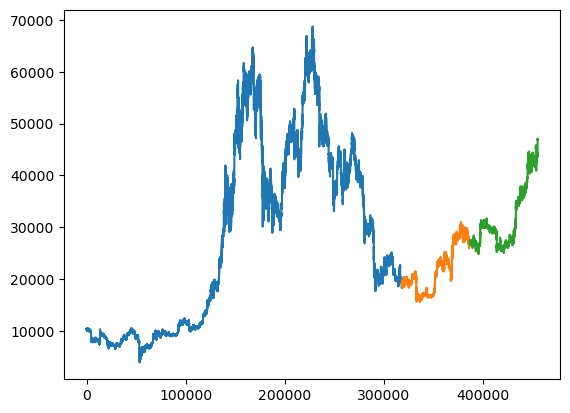

In [12]:
from matplotlib import pyplot as plt
plt.plot(np.arange(len(y_train)),y_train)
plt.plot( len(y_train) + np.arange(len(y_val)),y_val)
plt.plot(len(y_train)  + len(y_val) + np.arange(len(y_test)),y_test)

In [13]:
from keras.layers import LSTM
from keras.layers import Dense, Dropout
n_steps = 10
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences = True ,input_shape=(n_steps, n_features))) 
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.15))
model.add(Dense(64,activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(32,activation = "relu"))
model.add(Dropout(0.05))
model.add(Dense(16,activation = "relu"))
model.add(Dense(1))
model.compile(optimizer='adam' ,loss='mse', metrics = ['mae'])
# fit model

In [14]:
hist = model.fit(X_train, y_train, validation_data = (X_val,y_val) , epochs=1, verbose=1)
# demonstrate prediction

9956/9956 [==============================] - 62s 6ms/step - loss: 340273472.0000 - mae: 16356.1250 - val_loss: 54143740.0000 - val_mae: 6246.3638


In [15]:
hist.history

{'loss': [340273472.0],
 'mae': [16356.125],
 'val_loss': [54143740.0],
 'val_mae': [6246.36376953125]}

In [23]:
model.predict(X_test)

2134/2134 [==============================] - 5s 2ms/step


array([[27794.287],
       [27794.287],
       [27794.287],
       ...,
       [27794.285],
       [27794.285],
       [27794.285]], dtype=float32)

In [16]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
import hopsworks
project = hopsworks.login()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) project0
	 (2) DD2223_lab1



Enter project to access:  2



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206996


In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="btc-predictor-lstm"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
#joblib.dump(model, model_dir + "/lstm_model.h5")
model.save(model_dir + "/lstm_model.h5")
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
model_lstm = mr.python.create_model(
    name="lstmModel", 
    metrics={"val_loss" : hist.history['val_loss'][0],"val_mae" : hist.history['val_mae'][0] },
    model_schema=model_schema,
    description="BTC price Predictor",
    version = 3
    
)

# Upload the model to the model registry, including all files in 'model_dir'
model_lstm.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2571984 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/218 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/206996/models/lstmModel/3


Model(name: 'lstmModel', version: 3)

In [ ]:
print(mr.python.create_model.__doc__)